In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import re
import nltk
import seaborn as sns
import os
import string
from nltk.corpus import stopwords

In [2]:
# Importar los datos de drive
from google.colab import drive
from google.colab import files
import io
drive.mount('/content/drive')

train = pd.read_csv('/content/drive/MyDrive/Tesis/train_modificado.csv')
test = pd.read_csv('/content/drive/MyDrive/Tesis/test_modificado.csv')

Mounted at /content/drive


In [3]:
TARGET_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

def load_dataset(df):
    text = df['full_text']
    targets = df[TARGET_COLS]
    return tf.data.Dataset.from_tensor_slices((text, targets))

raw_ds = load_dataset(train)

for text, targets in raw_ds.take(3):
    print(text)
    print(targets, '\n')

tf.Tensor(b'wouldnt you want to have time and do your homework after school so you wouldnt have to do it later if you were to go after school and do your homework so you wouldnt do it later you would have much more time to do things you can go outside and hangout with friends without any concern about doing projects or homework also if you do your homework you can have time to go study for a test or and you can study to take a retake test or quiz and bring your grade up and if you do your homework after school you can have massive time to relax you can lay down and take a little nap or play on your phone with friends and you can take a little walk or play in the playground and you will not have a worry in the world and finally you can do community service hours for the school community service hours can help you pass the year and gives you time to work hard and maybe have fun with some friends of yours and you can have fun even if you are walking a dog or watching someones cat you woul

In [4]:
MAX_TOKENS = 50000
bag_vectorization = tf.keras.layers.TextVectorization(
    ngrams=4,
    max_tokens=MAX_TOKENS,
    output_mode="multi_hot",
)
text_only_ds = raw_ds.map(lambda x, y: x)
bag_vectorization.adapt(text_only_ds)
print(f'\nThe first 100 tokens in this vocabulary: {bag_vectorization.get_vocabulary()[:100]}\n')
print(f'\nThe last 100 tokens in this vocabulary: {bag_vectorization.get_vocabulary()[-100:]}\n')


The first 100 tokens in this vocabulary: ['[UNK]', 'to', 'the', 'and', 'you', 'a', 'that', 'is', 'in', 'they', 'i', 'not', 'it', 'have', 'of', 'for', 'be', 'do', 'can', 'because', 'are', 'people', 'students', 'school', 'will', 'or', 'with', 'if', 'we', 'your', 'their', 'what', 'more', 'my', 'but', 'time', 'get', 'on', 'good', 'work', 'like', 'when', 'this', 'some', 'would', 'want', 'them', 'life', 'help', 'at', 'make', 'so', 'do not', 'about', 'to be', 'think', 'there', 'has', 'all', 'to do', 'one', 'from', 'in the', 'how', 'other', 'also', 'he', 'was', 'something', 'need', 'know', 'want to', 'should', 'me', 'things', 'going', 'it is', 'just', 'better', 'person', 'go', 'by', 'as', 'have to', 'take', 'example', 'you can', 'always', 'our', 'if you', 'student', 'doing', 'way', 'learn', 'have a', 'many', 'up', 'who', 'of the', 'classes']


The last 100 tokens in this vocabulary: ['what heshe', 'what he wrote', 'what he was', 'what he has', 'what ever they want', 'what do you do', 'what co

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_df, val_df = train_test_split(train, test_size=0.1, random_state=42)

In [7]:
BUFFER_SIZE = len(train_df)
BATCH_SIZE = 8
AUTO = tf.data.experimental.AUTOTUNE

def get_train_ds():
    ds = load_dataset(train_df)
    ds = ds.map(lambda x, y: (bag_vectorization(x), tf.cast(y, tf.float32)), num_parallel_calls=AUTO)
    ds = ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)
    return ds

def get_val_ds():
    ds = load_dataset(val_df)
    ds = ds.map(lambda x, y: (bag_vectorization(x), tf.cast(y, tf.float32)), num_parallel_calls=AUTO)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
    return ds

In [8]:
train_ds = get_train_ds()
val_ds = get_val_ds()

for inputs, targets in train_ds.take(1):
    print(f'Training inputs shape: {inputs.shape}')
    print(f'Training inputs dtype: {inputs.dtype}')
    print(f'Training targets shape: {targets.shape}')
    print(f'Training targets dtype: {targets.dtype}')

for inputs, targets in val_ds.take(1):
    print(f'Validation inputs shape: {inputs.shape}')
    print(f'Validation inputs dtype: {inputs.dtype}')
    print(f'Validation targets shape: {targets.shape}')
    print(f'Validation targets dtype: {targets.dtype}')

Training inputs shape: (8, 50000)
Training inputs dtype: <dtype: 'float32'>
Training targets shape: (8, 6)
Training targets dtype: <dtype: 'float32'>
Validation inputs shape: (8, 50000)
Validation inputs dtype: <dtype: 'float32'>
Validation targets shape: (8, 6)
Validation targets dtype: <dtype: 'float32'>


#Model

In [9]:
def root_mean_squared_error(y_true, y_pred):
        return K.mean(K.sqrt(K.mean(K.square(y_pred - y_true), axis=0)))

In [10]:
def get_model(max_tokens=MAX_TOKENS, hidden_dim=16):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = tf.keras.layers.Dense(hidden_dim, activation="relu")(inputs)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(6)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                 loss=root_mean_squared_error,
                 metrics=['mse'],
                 )
    return model

In [11]:
from keras import backend as K

In [12]:
tf.keras.backend.clear_session()
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50000)]           0         
                                                                 
 dense (Dense)               (None, 16)                800016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 800118 (3.05 MB)
Trainable params: 800118 (3.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("./bag-of-words",
                                       monitor='val_loss',
                                       save_best_only=True,
                                       mode = 'min', verbose = 1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3,
                                         patience = 2, min_lr = 1e-8,
                                         mode = 'min', verbose = 1)
]
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=callbacks)

Epoch 1/20
349/352 [============================>.] - ETA: 0s - loss: 1.2464 - mse: 1.6935
Epoch 1: val_loss improved from inf to 0.72843, saving model to ./bag-of-words
352/352 [==============================] - 9s 17ms/step - loss: 1.2452 - mse: 1.6901 - val_loss: 0.7284 - val_mse: 0.5613 - lr: 0.0010
Epoch 2/20
351/352 [============================>.] - ETA: 0s - loss: 1.1772 - mse: 1.4750
Epoch 2: val_loss improved from 0.72843 to 0.64576, saving model to ./bag-of-words
352/352 [==============================] - 6s 12ms/step - loss: 1.1770 - mse: 1.4742 - val_loss: 0.6458 - val_mse: 0.4419 - lr: 0.0010
Epoch 3/20
351/352 [============================>.] - ETA: 0s - loss: 1.0113 - mse: 1.0970
Epoch 3: val_loss did not improve from 0.64576
352/352 [==============================] - 8s 14ms/step - loss: 1.0121 - mse: 1.0985 - val_loss: 0.6937 - val_mse: 0.5099 - lr: 0.0010
Epoch 4/20
348/352 [============================>.] - ETA: 0s - loss: 0.8923 - mse: 0.8490
Epoch 4: val_loss impr

<Axes: >

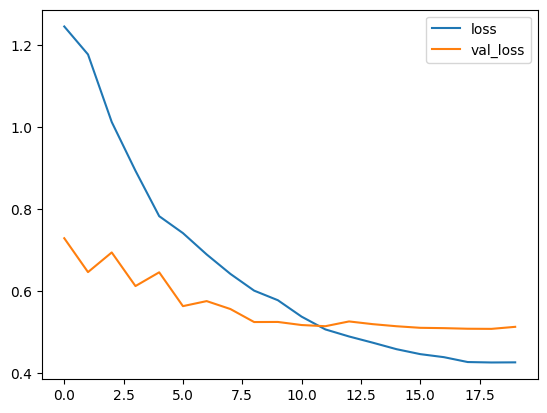

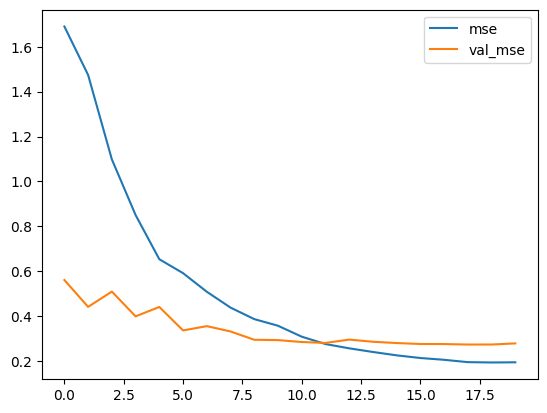

In [14]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['mse', 'val_mse']].plot()

In [15]:
preds_list = []
for index, row in test.iterrows():
    preds = model.predict(
        tf.expand_dims(
            bag_vectorization(tf.convert_to_tensor(row['full_text'])),
            axis=0
        )
    )
    preds = np.clip(preds, 1, 5)
    preds_list.append(preds[0])

1/1 [==============================] - 0s 23ms/step


In [16]:
preds_df = pd.DataFrame(preds_list, columns=['cohesion_pred', 'syntax_pred', 'vocabulary_pred', 'phraseology_pred', 'grammar_pred', 'conventions_pred'])
preds_df.head()

,cohesion_pred,syntax_pred,vocabulary_pred,phraseology_pred,grammar_pred,conventions_pred
0,2.527476,2.433598,2.706600,2.491318,2.367133,2.469814
1,3.103832,3.020108,3.216769,3.095765,3.032075,3.004087
2,3.485057,3.356894,3.546967,3.454348,3.377351,3.335189
3,2.995517,2.903366,3.132130,2.988454,2.888352,2.906355
4,3.530716,3.470226,3.583267,3.540255,3.559371,3.481040


In [17]:
preds_df

,cohesion_pred,syntax_pred,vocabulary_pred,phraseology_pred,grammar_pred,conventions_pred
0,2.527476,2.433598,2.706600,2.491318,2.367133,2.469814
1,3.103832,3.020108,3.216769,3.095765,3.032075,3.004087
2,3.485057,3.356894,3.546967,3.454348,3.377351,3.335189
3,2.995517,2.903366,3.132130,2.988454,2.888352,2.906355
4,3.530716,3.470226,3.583267,3.540255,3.559371,3.481040
...,...,...,...,...,...,...
778,3.125584,3.044740,3.231530,3.115103,3.068272,3.044077
779,2.961704,2.882339,3.099468,2.953777,2.877984,2.883921
780,2.897371,2.858889,3.049291,2.927950,2.874524,2.863045
781,3.914969,3.776783,3.926389,3.895339,3.841853,3.721070


In [18]:
test

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,...,max_sent_len,min_sent_len,med_sent_len,std_sent_len,num_sent,compound,negative,positive,neutral,char_len
0,1552,772D27D400BB,it god to have a possitive attitude when you d...,3.0,2.5,2.5,2.0,2.0,2.0,198,...,54,0,39.0,17.293387,7,0.9693,0.087,0.162,0.751,424
1,2114,9E8F3C6405CA,why do people ask more then one person for adv...,3.0,2.0,3.0,3.5,3.0,3.0,113,...,51,0,43.0,19.450793,6,0.9735,0.045,0.127,0.828,278
2,1965,948771F795EB,we accomplish more when we are active and are ...,4.0,4.0,3.0,4.0,4.0,4.0,220,...,26,0,17.0,5.815045,23,0.9983,0.041,0.223,0.735,440
3,3856,FE14D7378CFB,do you agree or disagree about imagination bei...,3.0,3.0,3.5,3.0,3.5,3.5,188,...,33,10,24.5,6.474308,12,0.3327,0.077,0.089,0.834,347
4,1610,7AAE019F70D6,i disagree with the principal saying that all ...,3.5,3.5,3.5,3.5,3.0,3.5,246,...,62,17,46.0,16.215348,8,-0.9820,0.117,0.061,0.821,444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,1740,83B3CD03C693,an enjoyable educational activity could be pla...,2.0,2.5,3.0,3.0,3.5,2.0,141,...,41,0,21.0,11.545129,10,0.9947,0.000,0.225,0.775,240
779,3760,F9D0974B3AF7,i disagree about extending school becauseparen...,2.5,2.5,3.0,3.0,2.5,2.5,127,...,33,0,13.0,9.839203,11,0.9647,0.008,0.133,0.859,218
780,1885,8E2EB0B4B92C,the author ralph waldo emerson once wrote to b...,2.0,3.0,3.0,3.0,3.0,2.5,291,...,37,0,17.0,7.035672,27,0.9988,0.054,0.228,0.718,484
781,2390,B1BF25C4C28B,my mom always tell me keep going until you rea...,4.0,3.5,4.0,3.5,3.5,4.0,292,...,31,0,21.0,6.945963,25,0.9856,0.084,0.140,0.777,531


In [19]:
test.reset_index(drop=True, inplace=True)
preds_df.reset_index(drop=True, inplace=True)

In [20]:
preresults =pd.concat([test, preds_df], axis=1);preresults

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,...,negative,positive,neutral,char_len,cohesion_pred,syntax_pred,vocabulary_pred,phraseology_pred,grammar_pred,conventions_pred
0,1552,772D27D400BB,it god to have a possitive attitude when you d...,3.0,2.5,2.5,2.0,2.0,2.0,198,...,0.087,0.162,0.751,424,2.527476,2.433598,2.706600,2.491318,2.367133,2.469814
1,2114,9E8F3C6405CA,why do people ask more then one person for adv...,3.0,2.0,3.0,3.5,3.0,3.0,113,...,0.045,0.127,0.828,278,3.103832,3.020108,3.216769,3.095765,3.032075,3.004087
2,1965,948771F795EB,we accomplish more when we are active and are ...,4.0,4.0,3.0,4.0,4.0,4.0,220,...,0.041,0.223,0.735,440,3.485057,3.356894,3.546967,3.454348,3.377351,3.335189
3,3856,FE14D7378CFB,do you agree or disagree about imagination bei...,3.0,3.0,3.5,3.0,3.5,3.5,188,...,0.077,0.089,0.834,347,2.995517,2.903366,3.132130,2.988454,2.888352,2.906355
4,1610,7AAE019F70D6,i disagree with the principal saying that all ...,3.5,3.5,3.5,3.5,3.0,3.5,246,...,0.117,0.061,0.821,444,3.530716,3.470226,3.583267,3.540255,3.559371,3.481040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,1740,83B3CD03C693,an enjoyable educational activity could be pla...,2.0,2.5,3.0,3.0,3.5,2.0,141,...,0.000,0.225,0.775,240,3.125584,3.044740,3.231530,3.115103,3.068272,3.044077
779,3760,F9D0974B3AF7,i disagree about extending school becauseparen...,2.5,2.5,3.0,3.0,2.5,2.5,127,...,0.008,0.133,0.859,218,2.961704,2.882339,3.099468,2.953777,2.877984,2.883921
780,1885,8E2EB0B4B92C,the author ralph waldo emerson once wrote to b...,2.0,3.0,3.0,3.0,3.0,2.5,291,...,0.054,0.228,0.718,484,2.897371,2.858889,3.049291,2.927950,2.874524,2.863045
781,2390,B1BF25C4C28B,my mom always tell me keep going until you rea...,4.0,3.5,4.0,3.5,3.5,4.0,292,...,0.084,0.140,0.777,531,3.914969,3.776783,3.926389,3.895339,3.841853,3.721070


In [21]:
preresults["se_cohesion"]=(preresults["cohesion"]-preresults["cohesion_pred"])**2
preresults["se_syntax"]=(preresults["syntax"]-preresults["syntax_pred"])**2
preresults["se_vocabulary"]=(preresults["vocabulary"]-preresults["vocabulary_pred"])**2
preresults["se_phraseology"]=(preresults["phraseology"]-preresults["phraseology_pred"])**2
preresults["se_grammar"]=(preresults["grammar"]-preresults["grammar_pred"])**2
preresults["se_conventions"]=(preresults["conventions"]-preresults["conventions_pred"])**2

In [22]:
results = pd.DataFrame()
results["se_cohesion"]=(preresults["cohesion"]-preresults["cohesion_pred"])**2
results["se_syntax"]=(preresults["syntax"]-preresults["syntax_pred"])**2
results["se_vocabulary"]=(preresults["vocabulary"]-preresults["vocabulary_pred"])**2
results["se_phraseology"]=(preresults["phraseology"]-preresults["phraseology_pred"])**2
results["se_grammar"]=(preresults["grammar"]-preresults["grammar_pred"])**2
results["se_conventions"]=(preresults["conventions"]-preresults["conventions_pred"])**2

In [23]:
results

,se_cohesion,se_syntax,se_vocabulary,se_phraseology,se_grammar,se_conventions
0,0.223279,0.004409,0.042683,0.241393,0.134787,0.220725
1,0.010781,1.040621,0.046989,0.163406,0.001029,0.000017
2,0.265166,0.413585,0.299172,0.297736,0.387692,0.441973
3,0.000020,0.009338,0.135328,0.000133,0.374113,0.352414
4,0.000943,0.000886,0.006933,0.001620,0.312895,0.000359
...,...,...,...,...,...,...
778,1.266940,0.296742,0.053606,0.013249,0.186389,1.090096
779,0.213170,0.146183,0.009894,0.002137,0.142872,0.147395
780,0.805274,0.019912,0.002430,0.005191,0.015744,0.131801
781,0.007230,0.076609,0.005419,0.156293,0.116864,0.077802


In [24]:
mse = results.mean();mse

se_cohesion       0.302882
se_syntax         0.284585
se_vocabulary     0.233026
se_phraseology    0.285923
se_grammar        0.343054
se_conventions    0.328379
dtype: float64

In [25]:
rmse = np.sqrt(mse);rmse

se_cohesion       0.550347
se_syntax         0.533465
se_vocabulary     0.482728
se_phraseology    0.534718
se_grammar        0.585708
se_conventions    0.573044
dtype: float64

In [26]:
np.mean(rmse)

0.5433348464930469